In [1]:
# !pip install treys
# !pip install termcolor
# !pip install pandas

In [2]:
import PIL.Image
import numpy as np
from typing import Union
from glob import glob
import pandas as pd
import os
# from treys import card
# from termcolor import colored
# from utils import eval_listof_games, debug_listof_games, save_results, load_results

from our_utils import deskew

# [IAPR][iapr]: Project


**Group ID:** xx

**Author 1 (sciper):** Student Name 1 (xxxxx)  
**Author 2 (sciper):** Student Name 2 (xxxxx)   
**Author 3 (sciper):** Student Name 3 (xxxxx)   

**Release date:** 29.04.2022


## Important notes

The assignments are designed to teach practical implementation of the topics presented during class as well as preparation for the final project, which is a practical project which ties together the topics of the course. 

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook !** rerun the notebook from scratch `Kernel` > `Restart & Run All`


[iapr]: https://github.com/LTS5/iapr

---
## 0. Introduction

An anonymous card player that we will name Bartick Pruel is willing to improve his poker skills. To do so, he asked our lab to design a tool that will automatically detect the hands of the players around the table. 

---

## 1. Data

To achieve your task, you will be given images that look like this (without the overlay)

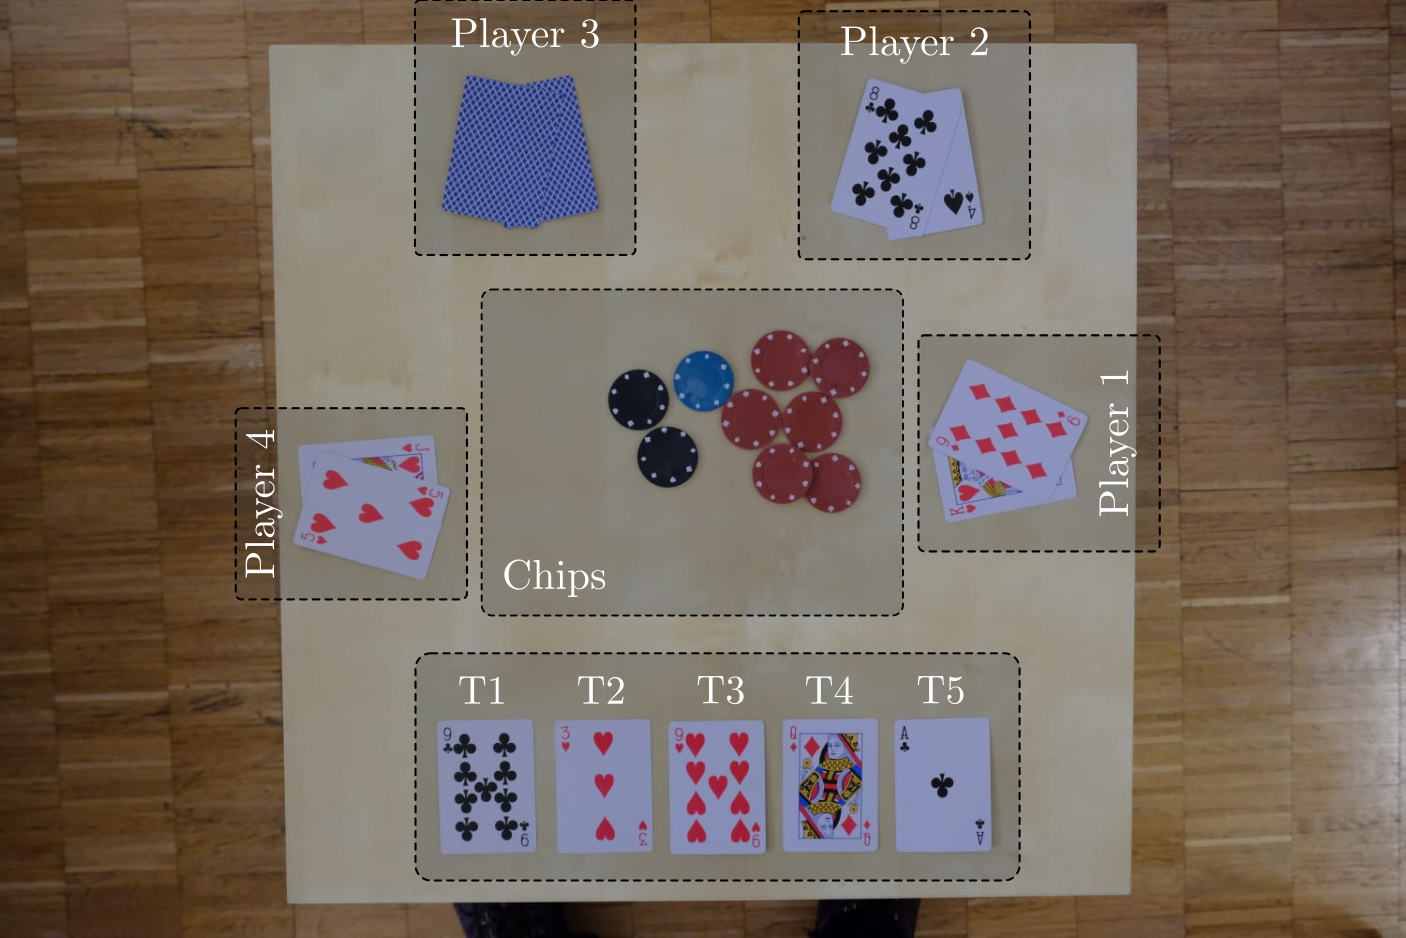


### 1.1. Table layout

The table is divided into 3 main parts:
* **Table cards (T1-T5)**: These cards are shared by every player. They are defined as the flop (T1-T3), the turn (T4) and the river (T5). The table cards are *always* visible.
* **Player cards (P11-P42)**: The cards played by each player (4 pairs). Each player *always* has 2 cards in hand. When a player is not playing, you can see the back of the cards (ex: player 3 here).
* **Chips**: The chips at the center of the table are named the pot.

### 1.2. Cards & Chips

The cards deck are composed of 52 cards split into 4 different colors: (D)imanond, (H)eart, (S)pade, (C)lub. Each color is composed of 13 different cards: 2, 3, 4, 5, 6, 7, 8, 9, 10, (J)ack, (Q)ueen, (K)ing and (A)ce.

Th chips can be of 5 different colors: (r)ed, (g)reen, (b)lue, blac(k) or (w)hite.


### 1.3 Structure

You can download the data for the project here: [download data](https://drive.google.com/file/d/1d7rOe88kEK1CEaLvYgNZkxrtKImLVC9X/view)

```
data 
│
└─── image_setup
│    │    back_cards.jpg      # Back of the cards (either blue or red)
│    │    chips.jpg           # Set of chips used (red, green, blue, black, white)
│    │    kings.jpg           # Kings from the 4 colors (diamond, heart, spade, club)
│    │    spades_suits.jpg    # All cards of spades (2 - 10, Jack, Queen, King, Ace)
│    │    table.jpg           # Empty table
│    └─── ultimate_test.jpg   # If it works on that image, you would probably end up with a good score
│
└─── train
│    │    train_00.jpg        # Train image 00
│    │    ...
│    │    train_27.jpg        # Train image 27
│    └─── train_labels.csv    # Ground truth of the train set
│
└─── test
     │    test_00.jpg         # Test image 00 (day of the exam only)
     │    ...
     └─── test_xx             # Test image xx (day of the exam only)
```


---

## 2. Tasks


Your task is to predict the following parameters for a set of images.

* **T1** (str): String code of the first card of the flop (far left) 
* **T2** (str): String code of the second card of the flop
* **T3** (str): String code of the third card of the flop
* **T4** (str): String code of the turn
* **T5** (str): String code of the river


* **P11** (str or int): String code of player 1 card 1. Should be 0 if player 1 is not Playing.
* **P12** (str or int): String code of player 1 card 2. Should be 0 if player 1 is not Playing.
* **P21** (str or int): String code of player 2 card 1. Should be 0 if player 2 is not Playing.
* **P22** (str or int): String code of player 2 card 2. Should be 0 if player 2 is not Playing.
* **P31** (str or int): String code of player 3 card 1. Should be 0 if player 3 is not Playing.
* **P32** (str or int): String code of player 3 card 2. Should be 0 if player 3 is not Playing.
* **P41** (str or int): String code of player 4 card 1. Should be 0 if player 4 is not Playing.
* **P42** (str or int): String code of player 4 card 2. Should be 0 if player 5 is not Playing.


* **CR** (int): Number of (r)ed chips in the pot
* **CG** (int): Number of (g)reen chips in the pot
* **CB** (int): Number of (b)lue chips in the pot
* **CK** (int): Number of blac(k) chips in the pot
* **CW** (int): Number of (w)hite chips in the pot


The output is saved using the function **save_results** as presented below.

---
## 3. Evaluation

**Before the exam**
   - Create a zipped folder named **groupid_xx.zip** that you upload on moodle (xx being your group number).
   - Include a **runnable** code (Jupyter Notebook and external files) and your presentation in the zip folder.
   
**The day of the exam**
   - You will be given a **new folder** with few images, but **no ground truth** (csv file).
   - We will ask you to run your pipeline in **real time** and to send us your prediction of the task you obtain with the provided function **save_results**. 
   - On our side, we will compute the performance of your classification algorithm. 
   - To evaluate your method, we will use the **evaluate_game** function presented below. To understand how the provided functions work, please read the documentation of the functions in **utils.py**.
   - **Please make sure your function returns the proper data format to avoid points penalty on the day of the exam**. 
---


## 4. Your code

In [66]:
def process_image(image) -> dict:
    """
    Process image and return information. To return the value of the cards we use 
    the following format: {number}{color}. Where 
        - color is either (D)imanond, (H)eart, (S)pade, (C)lub
        - number is either 2-10, (J)ack, (Q)ueen, (K)ing. A(ce).
            
    Parameters
    ----------
    image:
        Input image to process

    Returns
    -------
    results:
        - T1 (str): String code of the first card of the flop (far left) 
        - T2 (str): String code of the second card of the flop
        - T3 (str): String code of the third card of the flop
        - T4 (str): String code of the turn
        - T5 (str): String code of the river
        - P11 (str or int): String code of player 1 card 1. Should be 0 if player 1 is not Playing.
        - P12 (str or int): String code of player 1 card 2. Should be 0 if player 1 is not Playing.
        - P21 (str or int): String code of player 2 card 1. Should be 0 if player 2 is not Playing.
        - P22 (str or int): String code of player 2 card 2. Should be 0 if player 2 is not Playing.
        - P31 (str or int): String code of player 3 card 1. Should be 0 if player 3 is not Playing.
        - P32 (str or int): String code of player 3 card 2. Should be 0 if player 3 is not Playing.
        - P41 (str or int): String code of player 4 card 1. Should be 0 if player 4 is not Playing.
        - P42 (str or int): String code of player 4 card 2. Should be 0 if player 4 is not Playing.
        - CR (int): Number of (r)ed chips in the pot
        - CG (int): Number of (g)reen chips in the pot
        - CB (int): Number of (b)lue chips in the pot
        - CK (int): Number of blac(k) chips in the pot
        - CW (int): Number of (w)hite chips in the pot
        
    Examples
    --------
    - QH: Queen of hearths
    - 10S: 10 of spades
    - AC: Ace f clubs

    """
    
    # TODO: Amazing student code
    
    dummy_results = {
        # Flop, river and turn
        "T1": "2C", "T2": "AH", "T3": "8D", "T4": "JC", "T5": "JS",
        # Player cards
        "P11": '2H' , "P12": '3C', "P21": 'KS', "P22": "QS", "P31": "KD", "P32":"5S" , "P41": "7H", "P42": "8H",
        # Chips
         "CR": 1, "CG": 1, "CB": 1,"CK": 5, "CW": 0
    }
    return dummy_results


Working example

In [4]:
## load train size dataset
path_data = os.path.join("data", "train")
group_id = 0

In [5]:
## load train size dataset
train_size = np.loadtxt(os.path.join(path_data, "train_size.txt")).astype(int)
print("Size of trainset:\n\t{}".format(train_size))

# Load images from folder
game_results = {}

# Evaluate three images
games_id = [0,3]  # to evaluate  three images

for i in games_id :
    file = os.path.join(path_data, f"train_{str(i).zfill(2)}.jpg")
    # open the image
    im = PIL.Image.open(file)
    # Process the image
    results = process_image(image=im)
    # Append result to array
    game_results[i] = results

# Outputs prediction of game 0
print("Prediciton game:\n\t{}: {}".format(0, game_results[0]))

Size of trainset:
	28
Prediciton game:
	0: {'T1': '2C', 'T2': 'AH', 'T3': '8D', 'T4': 'JC', 'T5': 'JS', 'P11': '2H', 'P12': '3C', 'P21': 'KS', 'P22': 'QS', 'P31': 'KD', 'P32': '5S', 'P41': '7H', 'P42': '8H', 'CR': 1, 'CG': 1, 'CB': 1, 'CK': 5, 'CW': 0}


In [73]:
from typing import List
import os

from scipy.fft import fft
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from skimage.transform import rotate
from skimage.morphology import binary_erosion, dilation, opening, closing, disk
from skimage.color import rgb2gray, rgb2hsv
from skimage.filters import median
from skimage.measure import find_contours
import cv2

import chris_utils
import importlib
importlib.reload(chris_utils)

<module 'chris_utils' from 'C:\\Users\\Jan Warhuus\\Desktop\\EPFL\\EE451\\Iapr_final_project\\chris_utils.py'>

(4000, 6000, 3) (4000, 6000, 3)


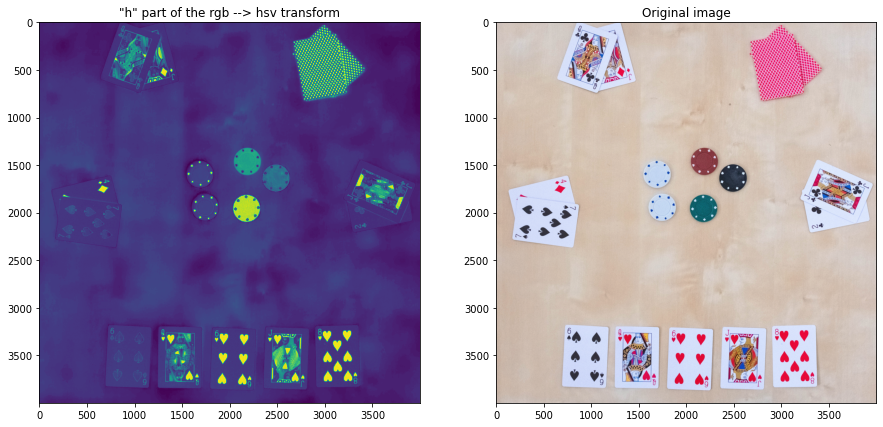

In [74]:
all_imgs, hsv_imgs = chris_utils.load_and_process_full_image(26)

array([0, 2, 3], dtype=int64)

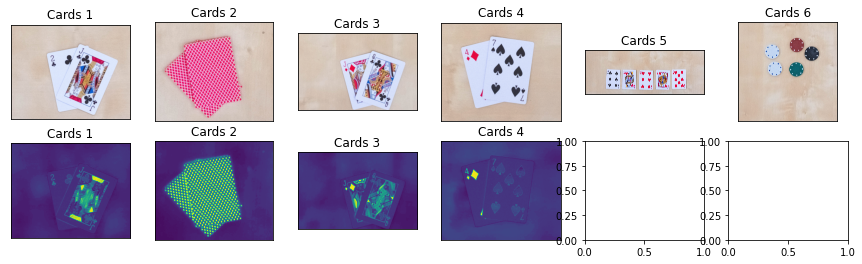

In [75]:
players, imgs, h_imgs = chris_utils.get_players_and_imgs(hsv_imgs, all_imgs)
players

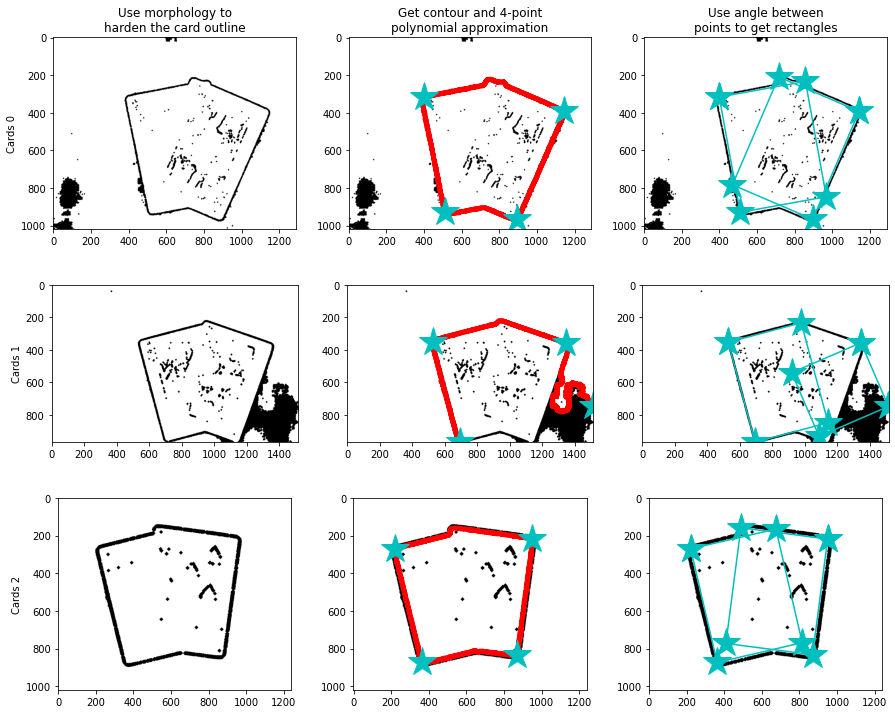

In [78]:
card_outlines = chris_utils.segment_cards(imgs, h_imgs)

ValueError: attempt to get argmax of an empty sequence

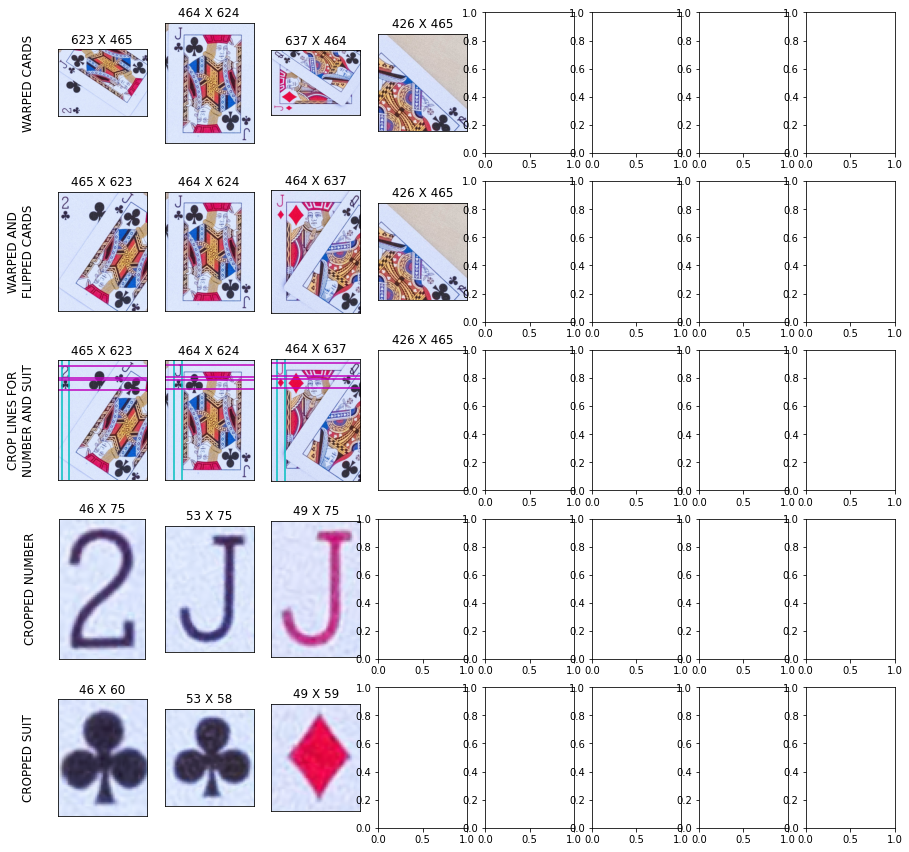

In [79]:
nums, types, num_signs = chris_utils.get_numbers_and_suits(card_outlines, imgs)

In [ ]:
numbers, number_contours = chris_utils.process_cutouts(nums)

In [ ]:
suits, suit_contours = chris_utils.process_cutouts(types)

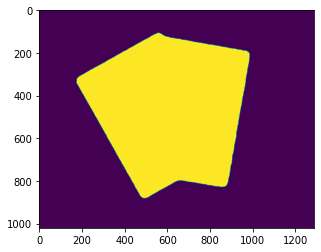

In [62]:
from skimage.morphology import binary_closing, binary_opening
from skimage.filters import median
import numpy as np
bin_cards = np.where(h_imgs[0] < 0.05, 1, 0)

# morphology
hey = median(binary_closing(bin_cards, disk(30)))
plt.imshow(hey)

# get all contours
wrong_shape_contours = find_contours(bin_cards)

# reshape contours and only take the longest ones
contours = [np.array([row.T[np.newaxis, :].round() for row in contour]).astype(np.int32)
            for contour in wrong_shape_contours if len(contour) > 1000]

# only take contours that fully encircle the center
fewer_contours = [contour for contour in contours
                  if chris_utils.contour_encircles_center(bin_cards, contour)]

for c in contours:
    plt.plot(c[:, :, 1], c[:, :, 0], 'r-')

In [ ]:
hey[200:210, 300:350]

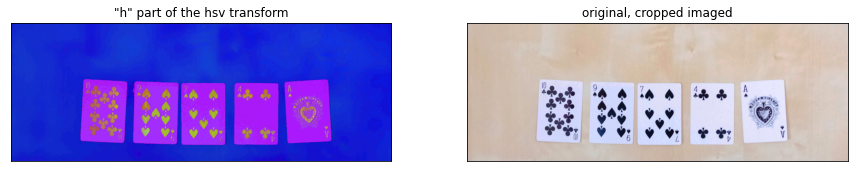

In [680]:
# now work on the test images
# transform to hsv and crop, only taking the "h"
# h = rgb2hsv(im)[500:3250, 1800:4000, 0]

# plot
fig, ax = plt.subplots(1, 2, figsize=(15, 3))
ax[0].imshow(h_table)
ax[0].set_title('"h" part of the hsv transform')
ax[1].imshow(table)
ax[1].set_title('original, cropped imaged')
for i in range(2):
    ax[i].set_yticks([])
    ax[i].set_xticks([])

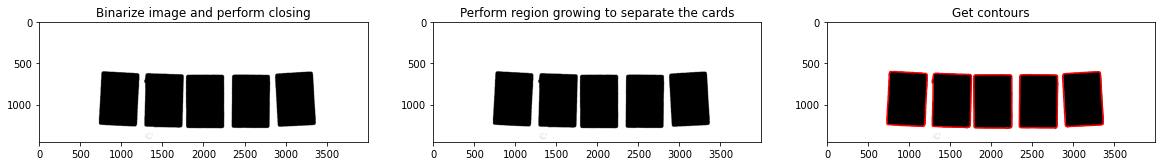

In [684]:
fig, ax = plt.subplots(1, 3, figsize=(20, 8))

# binarize images and perform a closing
bin_fig = opening(np.where(h_table[:, :, 0] < 0.15, 1, 0))
ax[0].imshow(bin_fig, cmap='gray')
_ = ax[0].set_title('Binarize image and perform closing')

# do region growing
new_fig = chris_utils.region_growing(bin_fig, (0.5, 1.))
ax[1].imshow(new_fig, cmap='gray')
_ = ax[1].set_title('Perform region growing to separate the cards')

# get contours
contours = find_contours(new_fig)
ax[2].imshow(new_fig, cmap='gray')
for c in contours:
    if len(c) > 2000:
        ax[2].plot(c[:, 1], c[:, 0], 'r')
_ = ax[2].set_title('Get contours')

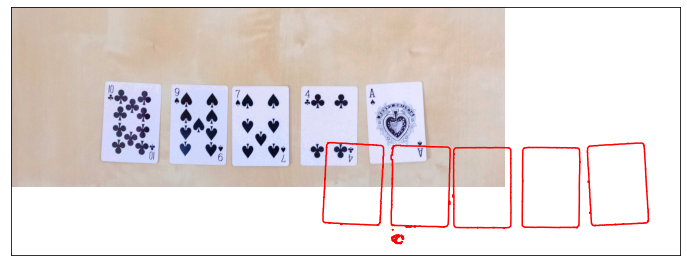

In [685]:
import cv2

# plot contours on original image
fig, ax = plt.subplots(1, 1, figsize=(12, 18))

# shift
# s_contours = [c + np.array([500, 1800]) for c in contours]
s_contours = contours

# plot contours on original image
rectangles = []
ax.imshow(table)
for contour in s_contours:
    ax.plot(contour[:, 1], contour[:, 0], c='r')
_ = ax.set_yticks([])
_ = ax.set_xticks([])    

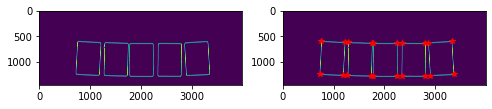

In [691]:
fig, ax = plt.subplots(1, 2, figsize=(8, 8))

# get contours using cv2 instead
cs, _ = cv2.findContours(np.where(new_fig, 0, 1).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

# create an empty image for contours
img_contours = np.zeros_like(new_fig)

# separate the card contours
cs1 = [c for c in cs if c.shape[0] > 1800]

# draw the contours to check them
cv2.drawContours(img_contours, cs1, -1, 1, 10)
ax[0].imshow(img_contours)

# box the contours
boxes, rects = [], []
for contour in cs1:
    rects += [cv2.minAreaRect(contour)]
    box = cv2.boxPoints(rects[-1])
    boxes += [np.int0(box)]
    for p in box:
        ax[1].plot(p[0], p[1], 'r*')
ax[1].imshow(img_contours)

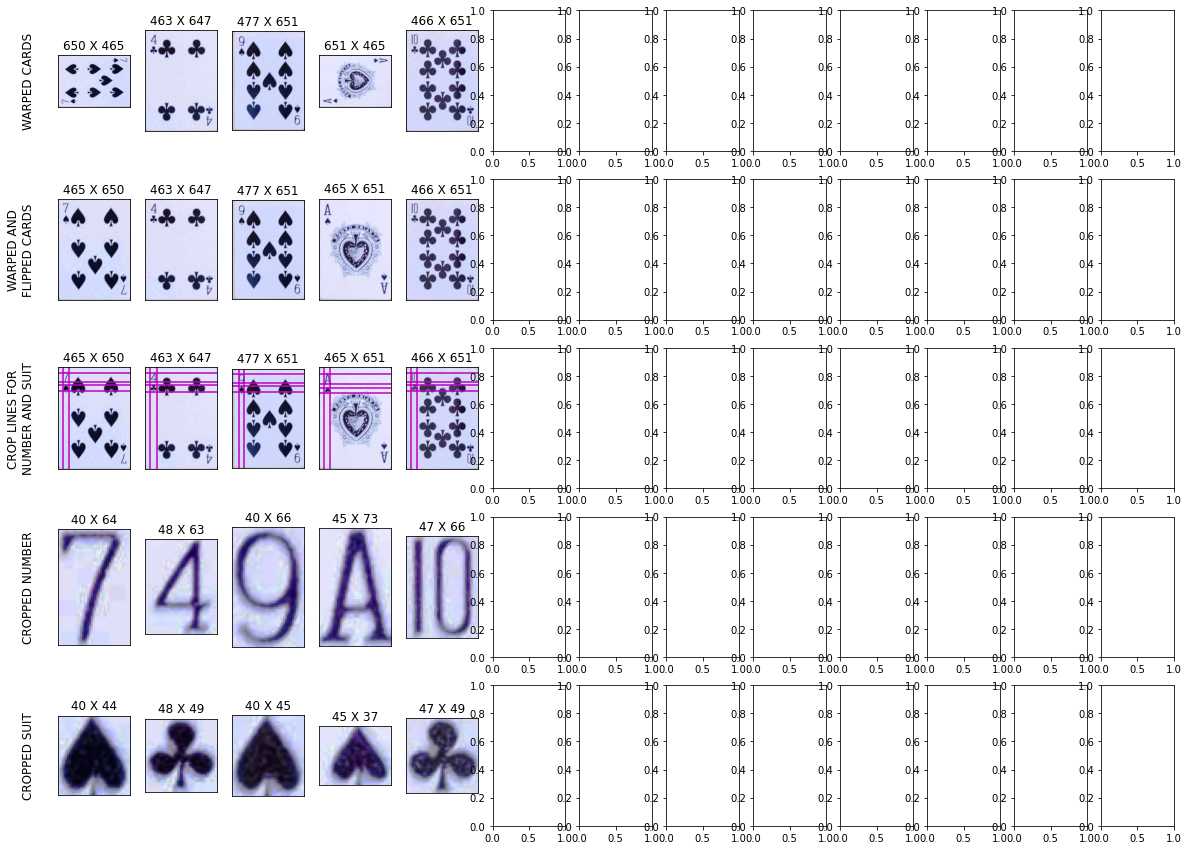

In [695]:
import matplotlib.patches as patches

# crop the rectagles and change their perspective
fig, axes = plt.subplots(5, 13, figsize=(20, 15))

# real boxes
shifted_boxes = boxes
# shifted_boxes = [box + np.array([1800, 500]) for box in boxes]

nums, types = [], []
num_signs = []
for i, (rect, box) in enumerate(zip(rects, shifted_boxes)):

    # get width and height of the detected rectangle
    width, height = int(rect[1][0]), int(rect[1][1])
    
    # coordinates of the box
    src_pts = box.astype("float32")

    # coordinate of the points in box points after the rectangle has been
    # straightened
    dst_pts = np.array([[0, height-1],
                        [0, 0],
                        [width-1, 0],
                        [width-1, height-1]], dtype="float32")

    # the perspective transformation matrix
    M = cv2.getPerspectiveTransform(src_pts, dst_pts)

    # directly warp the rotated rectangle to get the straightened rectangle
    warped = cv2.warpPerspective(table, M, (width, height))
    
    # plot the straightened rectangles
    axes[0, i].imshow(warped)
    axes[0, i].set_title(f'{warped.shape[1]} X {warped.shape[0]}')
    axes[0, i].set_xticks([])
    axes[0, i].set_yticks([])
    axes[0, 0].set_ylabel("WARPED CARDS\n", fontsize=12)
    
    # shift the rectangle if its laying on its side
    if warped.shape[0] < warped.shape[1]:
        warped = np.flip(np.stack([warped[:, :, i].T for i in range(3)], -1), 1)
    
    # show the straightened rectangles
    for j in range(1, 3):
        axes[j, i].imshow(warped)
        axes[j, i].set_title(f'{warped.shape[1]} X {warped.shape[0]}')
        axes[j, i].set_xticks([])
        axes[j, i].set_yticks([])
    axes[1, 0].set_ylabel("WARPED AND\nFLIPPED CARDS\n", fontsize=12)
    
    # save straightened image
    num_signs += [warped]
    
    # make image binary and apply a median filter to crop number and suit
    bin_im = np.where(rgb2gray(warped)[:, :] > 0.4, 1, 0)
    bin_im = median(bin_im)
    
    # find the uppermost and leftmost markinks on the card
    x = np.where(bin_im.T == 0)[0][0]
    y = np.where(bin_im == 0)[0][0]
    
    # find the bottom and rightmost edge of the number
    x_ = np.argmax(bin_im[y:200, x:200].sum(axis=0))
    y_ = np.argmax(bin_im[y:200, x:x + x_].sum(axis=1))
    
    # find the bottom and top of the suit
    ys = np.where(bin_im[y + y_:200, x:x + x_] == 0)[0][0]
    ys_ = np.argmax(bin_im[y + y_ + ys:200, x:x + x_].sum(axis=1))
    
    # plot the crop lines
    axes[2, i].axvline(x=x, c='m')
    axes[2, i].axvline(x=x + x_, c='m')
    axes[2, i].axhline(y=y, c='m')
    axes[2, i].axhline(y=y + y_, c='m')
    axes[2, i].axhline(y=y + y_ + ys, c='m')
    axes[2, i].axhline(y=y + y_ + ys + ys_, c='m')
    axes[2, 0].set_ylabel("CROP LINES FOR\nNUMBER AND SUIT\n", fontsize=12)
    
    # crop the numbers and show them
    nums += [num_signs[-1][y - 3:y + y_ + 3, x - 3:x + x_ + 3, :]]
    axes[3, i].imshow(nums[-1])
    axes[3, i].set_xticks([])
    axes[3, i].set_yticks([])
    axes[3, i].set_title(f'{nums[-1].shape[1]} X {nums[-1].shape[0]}')
    axes[3, 0].set_ylabel("CROPPED NUMBER\n", fontsize=12)
    
    # crop the suit and show them
    types += [num_signs[-1][y + y_ + ys - 3:y + y_ + ys + ys_ + 3, x - 3:x + x_ + 3, :]]
    axes[4, i].imshow(types[-1])
    axes[4, i].set_xticks([])
    axes[4, i].set_yticks([])
    axes[4, i].set_title(f'{types[-1].shape[1]} X {types[-1].shape[0]}')
    axes[4, 0].set_ylabel("CROPPED SUIT\n", fontsize=12)

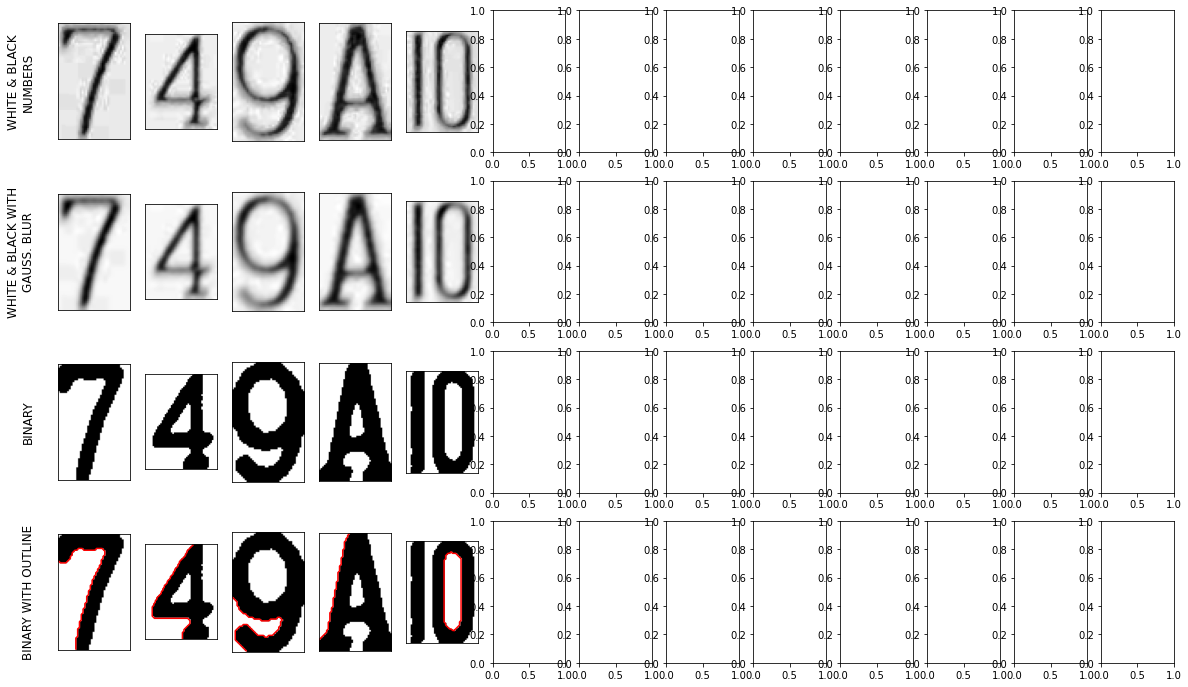

In [697]:
from skimage.filters import gaussian

fig, axes = plt.subplots(4, 13, figsize=(20, 12))

all_contours = []
bin_trans = []
for i in range(len(nums)):
    
    # show the black and white numbers
    axes[0, i].imshow(rgb2gray(nums[i]), cmap='gray')
    axes[0, i].set_xticks([])
    axes[0, i].set_yticks([])
    axes[0, 0].set_ylabel("WHITE & BLACK\nNUMBERS\n", fontsize=12)
    
    # apply a gaussian blur
    trans = gaussian(rgb2gray(nums[i]))
    axes[1, i].imshow(trans, cmap='gray')
    axes[1, i].set_xticks([])
    axes[1, i].set_yticks([])
    axes[1, 0].set_ylabel("WHITE & BLACK WITH\nGAUSS. BLUR\n", fontsize=12)
    
    # transform to binary and perform and opening
    bin_ = np.where(trans > 0.8, 1, 0)
    bin_trans += [opening(bin_)]
    for j in range(2, 4):
        axes[j, i].imshow(bin_trans[-1], cmap='gray')
        axes[j, i].set_xticks([])
        axes[j, i].set_yticks([])
    
    # get the contours and show the longest of these
    contours = find_contours(bin_trans[-1])
    axes[3, i].imshow(bin_trans[-1], cmap='gray')
    c = contours[np.argmax([len(contour) for contour in contours])]
    all_contours += [c]
    axes[3, i].plot(c[:, 1], c[:, 0], 'r')
    axes[2, 0].set_ylabel("BINARY\n", fontsize=12)
    axes[3, 0].set_ylabel("BINARY WITH OUTLINE\n", fontsize=12)

In [20]:
# get fourier descriptors of the longest contours
# des = get_fourier_descriptors(longest_contours)
# plt.scatter([abs(d[1] / d[0]) for d in des[:-1]],
#             [abs(d[2] / d[0]) for d in des[:-1]])

In [21]:
# Saving results
file_results = save_results(results=game_results, groupid=group_id)

In [22]:
# Checking the results were loaded correctly
loaded_results = load_results(file_results)
print(loaded_results.keys())

dict_keys(['0', '3'])


# Evaluation and Debugging

In [23]:
# Read training data
game_labels = pd.read_csv('data/train/train_labels.csv')
game_labels = game_labels.fillna('0')
game_labels

,Image,T1,T2,T3,T4,T5,P1.1,P1.2,P2.1,P2.2,P3.1,P3.2,P4.1,P4.2,R,G,B,K,W
0,Train_00,2C,6H,8D,JC,JS,2H,4S,KS,QS,KD,5S,7H,8H,1,1,1,1,1
1,Train_01,9H,8C,2H,4C,JS,0,0,3C,KH,KD,2D,QS,3S,2,0,1,0,1
2,Train_02,9D,3D,4C,6D,2H,7H,QD,10S,10C,5C,4S,2S,4H,0,0,8,1,0
3,Train_03,6D,KH,7H,KC,6H,QC,QS,3C,3D,4H,5D,2S,7C,0,2,4,0,0
4,Train_04,KC,3C,9C,QC,10C,8H,10D,AH,JD,3S,8S,5C,10S,3,1,1,0,2
5,Train_05,8H,6D,4C,7D,AC,3D,KS,9D,6S,0,0,7H,7C,2,1,2,1,0
6,Train_06,QS,5S,KS,KD,8C,0,0,6H,7D,8D,2C,JC,JD,1,0,0,0,0
7,Train_07,7C,AD,6C,KH,9D,2D,9H,0,0,0,0,4H,5D,1,0,1,2,0
8,Train_08,9C,4C,QC,7D,JD,QD,4D,9C,10C,9D,3C,5D,KC,0,0,0,0,0
9,Train_09,8H,6D,4C,7D,AC,3D,KS,9D,6S,0,0,7H,7C,2,1,2,1,0


In [24]:
# Evaluate
eval_listof_games( game_results , game_labels , game_id = games_id)

Game 0 results
Estimated game
['2C', 'AH', '8D', 'JC', 'JS', '2H', '3C', 'KS', 'QS', 'KD', '5S', '7H', '8H', 1, 1, 1, 5, 0]
True game
['2C' '6H' '8D' 'JC' 'JS' '2H' '4S' 'KS' 'QS' 'KD' '5S' '7H' '8H' 1 1 1 1
 1]


             	scores
Card number 	0.85 %
Card suit   	0.92 %
Chips       	0.17 %


FINAL score 	0.65 %
________________________________________
Game 3 results
Estimated game
['2C', 'AH', '8D', 'JC', 'JS', '2H', '3C', 'KS', 'QS', 'KD', '5S', '7H', '8H', 1, 1, 1, 5, 0]
True game
['6D' 'KH' '7H' 'KC' '6H' 'QC' 'QS' '3C' '3D' '4H' '5D' '2S' '7C' 0 2 4 0
 0]


             	scores
Card number 	0.08 %
Card suit   	0.15 %
Chips       	0.0 %


FINAL score 	0.08 %
________________________________________
Average SCORE =  0.36111111111111116


0.36111111111111116

In [25]:
# Debug
debug_listof_games( game_results , game_labels, game_id = games_id)

Game 0 results
Estimated game
['2C', 'AH', '8D', 'JC', 'JS', '2H', '3C', 'KS', 'QS', 'KD', '5S', '7H', '8H', 1, 1, 1, 5, 0]
True game
['2C' '6H' '8D' 'JC' 'JS' '2H' '4S' 'KS' 'QS' 'KD' '5S' '7H' '8H' 1 1 1 1
 1]




NameError: name 'Card' is not defined